# Extract wildlife observation data with SensingClues

[SensingClues](https://sensingclues.org/) allows you to record, monitor and analyze wildlife observations to support nature conservation initiatives. This notebook shows the following:

- **Core**: the main SensingClues-functionality of
    1. Extracting observation data
    2. Extracting track data
- **Advanced**: additional functionality including
    1. A hierarchy of available concepts (e.g. animal species or type of (illegal) activity), which enhances reporting and analysis of the observation data.
    2. Extraction and visualization of layer data from SensingClues.

You can adapt this notebook to extract your own observation data. For more detail on what you can configure as a user, see the API-documentation of the `sensingcluespy`-package [here](https://sensingcluespy.readthedocs.io/en/latest/).

### Before you start

To run this notebook, you should:
- Install the `sensingcluespy`-package in a virtual python environment (`pip install -e .` from the main directory of the repository).
- Install the requirements in requirements.txt (if not already installed automatically in the previous step). This includes the plotting libraries `matplotlib` and `folium` used in this notebook.

#### [Optional] Create your own user account

For the purpose of this tutorial, we use a **read-only** user called "demo". If you want to continue using SensingClues for your own work (of course you want to! :-) ), then please do the following:
- Create a personal account at SensingClues using the Cluey Data Collector app, which can be downloaded from the Google Playstore (not supported for iOS currently). Also see [here](https://sensingclues.org/portal).
- Create a file '.env' in the root of the wildcat-api-python-repository, containing your SensingClues credentials. These will be read in this notebook to log in. The file should look like this:
```
# SensingClues credentials
USERNAME=your_username
PASSWORD=your_password
```

## Configuration

In [1]:
# N.B. While sensingcluespy does not require you to install visualization packages, this tutorial does.
# To run this tutorial in full, please install matplotlib and folium (as contained in requirements.txt).
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

from sensingcluespy import sclogging
from sensingcluespy.api_calls import SensingClues
from sensingcluespy.src import helper_functions as helpers
from sensingcluespy.src import visualization as viz

In [2]:
plt.style.use("ggplot")

In [3]:
logger = sclogging.get_sc_logger()
sclogging.set_sc_log_level("INFO")

In [4]:
load_dotenv()

True

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# N.B. We recommend to place your credentials in an environment file and read them like so:
# username = os.getenv("USERNAME")
# password = os.getenv("PASSWORD")

# However, for the purpose of this demo, we use a read-only demo user:
username = "demo"
password = "demo"

## Connect to SensingClues

In [7]:
sensing_clues = SensingClues(username, password)

2024-11-15 10:52:34 [api_calls.py:57] INFO - Successfully logged in to SensingClues.


## Check available data

By default, you have access to several groups of data, such as a demo dataset and a large dataset offered by [Global Forest Watch](https://www.globalforestwatch.org).

In [8]:
info = sensing_clues.get_groups()
info

,name,description,n_records
0,focus-project-3494596,Demo Cluey Group,6
1,focus-project-1234,Demo Upload,797
2,focus-project-GFW,GFW,54767


In [9]:
# Specify the group(s) to extract data from
# For this tutorial, focus-project-1234 contains demo observations,
# while focus-project-3494596 contains demo tracks.
groups = [
    "focus-project-3494596",
    "focus-project-1234",
]

## Core functionality

Time to collect and plot some observation and track data!

### Get observations

You can filter the extracted observations in multiple ways, such as timestamps, coordinates (bounding box) and concepts. Some key features are shown here:

- **Date and time**: set `date_from` and/or `date_until` (in format %Y-%m-%d, assumes UTC).
- **Coordinates**: set `coord`, e.g. {"north": 32, "east": 20, "south": 31, "west": 17}.
- **Concepts**: set `concepts` to include, e.g. 'animal'. *See detailed example later in this notebook*.

For full detail on the options, see the documentation of the API [here](https://sensingcluespy.readthedocs.io/en/latest/).

#### Usage notes
- Reading all data in a group can take minutes or longer, depending on the size of the dataset. If you want to do a quick test, you can limit the number of pages to read by setting `page_nbr_sample`.
- Each observation has a unique `entityId` and may have multiple concepts (labels) associated with it, in which case the number of records in the observations-dataframe is larger than the number of observations mentioned by the logger.

In [10]:
# A quick check of the number of available records
obs_sample = sensing_clues.get_observations(groups=groups, page_nbr_sample=1)

2024-11-15 10:52:35 [api_calls.py:478] INFO - Scope ['focus-project-3494596', 'focus-project-1234'] contains 803 records for data type 'observations', when not applying any filters.
2024-11-15 10:52:35 [api_calls.py:492] INFO - When applying your filters, 801 records remain.
2024-11-15 10:52:36 [api_calls.py:531] INFO - Started  reading available records for group focus-project-3494596.
2024-11-15 10:52:36 [api_calls.py:549] INFO - Finished reading available records for group focus-project-3494596.
2024-11-15 10:52:36 [api_calls.py:531] INFO - Started  reading available records for group focus-project-1234.
2024-11-15 10:52:36 [api_calls.py:549] INFO - Finished reading available records for group focus-project-1234.


In [11]:
observations = sensing_clues.get_observations(
    groups=groups,
    date_from="2024-07-01",
    coord={"north": -17, "east": 30, "south": -19, "west": 20}
)

2024-11-15 10:52:36 [api_calls.py:478] INFO - Scope ['focus-project-3494596', 'focus-project-1234'] contains 803 records for data type 'observations', when not applying any filters.
2024-11-15 10:52:36 [api_calls.py:492] INFO - When applying your filters, 97 records remain.
2024-11-15 10:52:37 [api_calls.py:531] INFO - Started  reading available records for group focus-project-3494596.
2024-11-15 10:52:37 [api_calls.py:549] INFO - Finished reading available records for group focus-project-3494596.
2024-11-15 10:52:37 [api_calls.py:531] INFO - Started  reading available records for group focus-project-1234.
2024-11-15 10:52:38 [api_calls.py:549] INFO - Finished reading available records for group focus-project-1234.


#### Visualize these observations

The standard plotting-function `plot_observation` shows a separate layer for all observation types (typically ['community_work', 'animal', 'community', 'poi', 'hwc'], where 'poi' = 'point of interest' and 'hwc' = 'human-wildlife-conflict').

In [12]:
viz.plot_observations(
    observations, 
    show_heatmap="hwc_animal", 
    padding=(25, 25)
)

In [13]:
# You can explore the observations per observationType like so:
observation_type = "animal"
# observation_type = "hwc"
observations.loc[observations["observationType"] == observation_type, "conceptLabel"].value_counts()

Animal sighting    13
Elephant            2
Dropping            2
Photographed        2
_Fresh              2
Ibis                2
Kingfisher          1
Heron               1
Stork               1
Guineafowl          1
Name: conceptLabel, dtype: int64

### Get tracks

You can filter the extracted observations in multiple ways, such as data, coordinates (bounding box) and concepts, similar to `get_observations`. 

In [14]:
tracks = sensing_clues.get_tracks(
    groups=groups,
    # date_from="2024-07-01",
    # coord={"north": -17, "east": 30, "south": -19, "west": 20}
)

2024-11-15 10:52:39 [api_calls.py:478] INFO - Scope ['focus-project-3494596', 'focus-project-1234'] contains 803 records for data type 'tracks', when not applying any filters.
2024-11-15 10:52:39 [api_calls.py:492] INFO - When applying your filters, 2 records remain.
2024-11-15 10:52:39 [api_calls.py:531] INFO - Started  reading available records for group focus-project-3494596.
2024-11-15 10:52:39 [api_calls.py:549] INFO - Finished reading available records for group focus-project-3494596.
2024-11-15 10:52:39 [api_calls.py:508] WARNING - No data available for 'tracks', returning empty dataframe for group focus-project-1234.


In [15]:
tracks.head()

,entityId,entityType,projectId,projectName,featureType,length,startWhen,endWhen,agentName,patrolDuration_hours
0,G3494596-6fe952b4-9ab3-463e-82fd-5a2be1c8e85e,track,3494596,Demo Cluey Group,track/onVehiclePatrol,7.251837,2024-08-29 17:02:24+02:00,2024-08-29 18:39:42+02:00,jankees,1.621667
1,G3494596-0c3d987b-038f-400e-8b83-8b1694a026f5,track,3494596,Demo Cluey Group,track/onDuty,42.096071,2024-08-24 11:34:56+02:00,2024-08-24 22:31:42+02:00,jankees,10.946111


#### Visualize tracks

If available, you can add geojson-data (including geometries) to the tracks and subsequently visualize the tracks.

In [16]:
tracks_geo = sensing_clues.add_geojson_to_tracks(tracks)

In [17]:
track_map = viz.plot_tracks(tracks_geo["geometry"])
track_map

## Advanced functionality

### Get all available concepts and their hierarchy

SensingClues offers hierarchies containing the available concepts (e.g. animals). As shown later in this notebook, you can use this information to subsequently query:
- the details for a specific concept
- check the occurrence of each concept in the group(s) of observations you have access to.

In [18]:
hierarchy = sensing_clues.get_hierarchy(scope="SCCSS")
hierarchy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1236 entries, 0 to 1579
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1236 non-null   object
 1   parent        1236 non-null   object
 2   label         1236 non-null   object
 3   altLabels     771 non-null    object
 4   children      160 non-null    object
 5   isTopConcept  1236 non-null   bool  
dtypes: bool(1), object(5)
memory usage: 59.1+ KB


### Get details for specific concepts in the hierarchy

You can get information on children or the parents of a concept in the hierarchy by filtering on its label or id. Use the available helper functions to do so. For example, you could do the following for the concept of a "Kite" (oid = "https://sensingclues.poolparty.biz/SCCSSOntology/222"):

```
oid = "https://sensingclues.poolparty.biz/SCCSSOntology/222"
helpers.get_children_for_id(hierarchy, oid)
helpers.get_parent_for_id(hierarchy, oid)
helpers.get_label_for_id(hierarchy, oid)
```

or, if filtering on the label itself:

```
label = 'Kite'
helpers.get_children_for_label(hierarchy, label)
helpers.get_parent_for_label(hierarchy, label)
helpers.get_id_for_label(hierarchy, label)
```

N.B. Alternatively, you could directly filter the `hierarchy`-dataframe yourself of course.

#### Tell me, what animal belongs to this concept id?

In [19]:
oid = "https://sensingclues.poolparty.biz/SCCSSOntology/222"
helpers.get_label_for_id(hierarchy, oid)

'Kite'

#### Does this Kite have any child concepts?

In [20]:
label = "Kite"
children_label = helpers.get_children_for_label(hierarchy, label)
children_label

['https://sensingclues.poolparty.biz/SCCSSOntology/224',
 'https://sensingclues.poolparty.biz/SCCSSOntology/223']

#### What are the details for these children?

In [21]:
hierarchy.loc[hierarchy["id"].isin(children_label)]

,id,parent,label,altLabels,children,isTopConcept
461,https://sensingclues.poolparty.biz/SCCSSOntolo...,https://sensingclues.poolparty.biz/SCCSSOntolo...,Kite black,"[Black_kite, Kite_black, Milvus_migrans, Black...",NaN,False
1127,https://sensingclues.poolparty.biz/SCCSSOntolo...,https://sensingclues.poolparty.biz/SCCSSOntolo...,Kite red,"[red_kite, Kite_red, Milvus milvus, Milvus_mil...",NaN,False


### Filter observations on concept

Here we show an example of filtering the data on concepts. The example filters on the concepts of Impala and Giraffe.

**Instructions:**
- Set `concepts` to include, e.g. 'animal', specified as a Pool Party URL, e.g. "https://sensingclues.poolparty.biz/SCCSSOntology/186".
- Note that you can infer the URL's available for a certain common name by using the helper function `helpers.get_label_for_id(hierarchy, oid)`, as shown above.
- Further, if you want to exclude subconcepts, i.e. keep observations with the label 'animal' but exclude observations with the label 'elephant', set `include_subconcepts=False`.


In [22]:
concept_animal = [
    "https://sensingclues.poolparty.biz/SCCSSOntology/308", # Impala
    "https://sensingclues.poolparty.biz/SCCSSOntology/319", # Giraffe    
    
    # or infer the id using a label, for instance:
    # helpers.get_id_for_label(hierarchy, "Animal sighting"),
]
concept_observations = sensing_clues.get_observations(
    groups=groups,
    concepts=concept_animal,
    # date_from="2024-07-01",
    # coord={"north": -17, "east": 30, "south": -19, "west": 20}
)

2024-11-15 10:52:40 [api_calls.py:478] INFO - Scope ['focus-project-3494596', 'focus-project-1234'] contains 803 records for data type 'observations', when not applying any filters.
2024-11-15 10:52:41 [api_calls.py:492] INFO - When applying your filters, 8 records remain.
2024-11-15 10:52:41 [api_calls.py:508] WARNING - No data available for 'observations', returning empty dataframe for group focus-project-3494596.
2024-11-15 10:52:41 [api_calls.py:531] INFO - Started  reading available records for group focus-project-1234.
2024-11-15 10:52:41 [api_calls.py:549] INFO - Finished reading available records for group focus-project-1234.


In [23]:
concept_observations.head()

,entityId,entityType,entityName,projectId,projectName,observationType,when,where,agentName,conceptLabel,conceptId,lon,lat,geometry
0,O1234-6977171871396613895-2059,human activity,Observation,1234,Demo Upload,human activity,2024-06-24T00:00:00+02:00,"{'type': 'Point', 'coordinates': [24.75065, -1...",,Carcass,https://sensingclues.poolparty.biz/SCCSSOntolo...,24.75065,-17.50172,POINT (24.75065 -17.50172)
1,O1234-6977171871396613895-2059,human activity,Observation,1234,Demo Upload,human activity,2024-06-24T00:00:00+02:00,"{'type': 'Point', 'coordinates': [24.75065, -1...",,Giraffe,https://sensingclues.poolparty.biz/SCCSSOntolo...,24.75065,-17.50172,POINT (24.75065 -17.50172)
2,O1234-6977171871396613895-2059,human activity,Observation,1234,Demo Upload,human activity,2024-06-24T00:00:00+02:00,"{'type': 'Point', 'coordinates': [24.75065, -1...",,Machete,https://sensingclues.poolparty.biz/SCCSSOntolo...,24.75065,-17.50172,POINT (24.75065 -17.50172)
3,O1234-6977171871396613895-2059,human activity,Observation,1234,Demo Upload,human activity,2024-06-24T00:00:00+02:00,"{'type': 'Point', 'coordinates': [24.75065, -1...",,Recorded,https://sensingclues.poolparty.biz/SCCSSOntolo...,24.75065,-17.50172,POINT (24.75065 -17.50172)
4,O1234-6977171871396613895-2059,human activity,Observation,1234,Demo Upload,human activity,2024-06-24T00:00:00+02:00,"{'type': 'Point', 'coordinates': [24.75065, -1...",,Observations,https://sensingclues.poolparty.biz/SCCSSOntolo...,24.75065,-17.50172,POINT (24.75065 -17.50172)


### Count concepts related to observations

Get the number of observations per concept in the ontology (hierarchy).

You can filter on for instance:
- `date_from` and `date_until`.
- A list of child concepts, e.g. by extracting children for the label "Animal sighting" from hierarchy (see example below).

In [24]:
date_from = "2010-01-01"
date_until = "2024-08-01"
label = "Animal sighting"
children_label = helpers.get_children_for_label(hierarchy, label)
concept_counts = sensing_clues.get_concept_counts(
    groups, date_from=date_from, date_until=date_until, concepts=children_label
)
concept_counts.head()

,frequency,_value
0,43,https://sensingclues.poolparty.biz/SCCSSOntolo...
1,2,https://sensingclues.poolparty.biz/SCCSSOntolo...
2,3,https://sensingclues.poolparty.biz/SCCSSOntolo...
3,3,https://sensingclues.poolparty.biz/SCCSSOntolo...
4,2,https://sensingclues.poolparty.biz/SCCSSOntolo...


#### Example: visualize concept counts

To make the visualization intelligible, you can add information on labels from the `hierarchy`-dataframe.

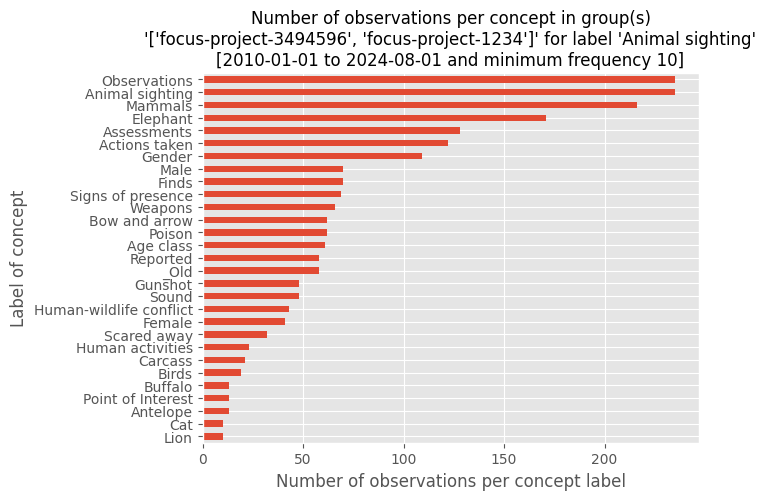

In [25]:
min_freq = 10
if not concept_counts.empty:
    concept_freq = concept_counts.merge(
        hierarchy, left_on="_value", right_on="id", how="left"
    )
    concept_freq["label"] = concept_freq["label"].fillna(concept_freq["_value"])
    concept_freq = concept_freq.set_index("label")["frequency"].sort_values(
        ascending=True
    )

    concept_freq.loc[concept_freq >= min_freq].plot(kind="barh")
    plt.title(
        f"Number of observations per concept in group(s)\n'{groups}' for label '{label}'\n"
        f"[{date_from} to {date_until} and minimum frequency {min_freq}]",
        fontsize=12,
    )
    plt.xlabel("Number of observations per concept label")
    plt.ylabel("Label of concept")

### Get layers

In [26]:
# check all available layers
layers = sensing_clues.get_all_layers()
layers

,pid,lid,layerName,description,geometryType
0,1234,0,Demo_places,All Point geometries for layer Demo_places,Point
1,1234,1,Demo_roads,All LineString geometries for layer Demo_roads,LineString
2,1234,2,Demo_countries,All MultiPolygon geometries for layer Demo_cou...,MultiPolygon
3,1234,3,Demo zones,All Polygon geometries for layer Demo zones,Polygon


### Visualize an individual layer

Get features for an individual and visualize it.

In [30]:
layer = sensing_clues.get_layer_features(layer_name="Demo_countries")
viz.plot_layer(layer)

### Miscellaneous

In [28]:
# You should have logged in automatically by calling the class.
# If not, you can call the login-method separately.
# status = sensing_clues.login(username, password)

In [29]:
# It is not necessary to log out, but you can do so by calling:
# sensing_clues.logout()